Testing the implementaion of positive and negative real values using 5 Qubits - 32 data points

The experimental code for developing Amplitude embedded circuits using Variational Quantum State Preparation (VQSP). The VQSP algorithm uses PQC to create training circuits which learns the parameters to create the corresponding amplitude embedded states.

In [1]:
# !pip install pennylane nftopt

We specify the number of qubits needed to map the data, for n qubits we can amplitude embedded 2^n data. The depth represents the ansatz repitition depth.

In [2]:
#defining parameters
n_qubits = 6 #( 5 + 1 ancillary)
depth = 4

Generating Random data points to be amplitude embedded.

In [3]:
import numpy as np
val_total = 2 ** (n_qubits - 1)
arr = np.random.uniform(low=-1, high=1,size=(val_total))
print(arr)

[-0.47791645  0.50830373 -0.95573146 -0.362758    0.51337288  0.78834847
  0.58282701 -0.10725523 -0.15327924  0.75226628 -0.75707974 -0.50793528
  0.98100309  0.6285297   0.977436   -0.48695036  0.69136052  0.18418806
 -0.79429021  0.15465492 -0.13388799  0.51942568 -0.14410164  0.93959518
 -0.12292955 -0.82114152 -0.47339701 -0.2825014   0.83937036  0.79333027
  0.33567151 -0.00476244]


In [4]:
np.unique(arr)

array([-0.95573146, -0.82114152, -0.79429021, -0.75707974, -0.50793528,
       -0.48695036, -0.47791645, -0.47339701, -0.362758  , -0.2825014 ,
       -0.15327924, -0.14410164, -0.13388799, -0.12292955, -0.10725523,
       -0.00476244,  0.15465492,  0.18418806,  0.33567151,  0.50830373,
        0.51337288,  0.51942568,  0.58282701,  0.6285297 ,  0.69136052,
        0.75226628,  0.78834847,  0.79333027,  0.83937036,  0.93959518,
        0.977436  ,  0.98100309])

Cumulating the negative towards the end of the array so that we can easily store the indices of negative elements.

In [5]:
# Rearranging the array so that there is no index confusion
arr1 = []
for i in range(len(arr)):
  if(arr[i] > 0):
    arr1.append(arr[i])

for i in range(len(arr)):
  if(arr[i] < 0):
    arr1.append(arr[i])

arr1 = np.array(arr1)
print(arr1)

[ 0.50830373  0.51337288  0.78834847  0.58282701  0.75226628  0.98100309
  0.6285297   0.977436    0.69136052  0.18418806  0.15465492  0.51942568
  0.93959518  0.83937036  0.79333027  0.33567151 -0.47791645 -0.95573146
 -0.362758   -0.10725523 -0.15327924 -0.75707974 -0.50793528 -0.48695036
 -0.79429021 -0.13388799 -0.14410164 -0.12292955 -0.82114152 -0.47339701
 -0.2825014  -0.00476244]


Normalizing the points by dividing by their sum

In [6]:
summer = np.sum(np.abs(arr1))
print(summer)
normalized_X = arr1/summer
print(normalized_X)

16.775601198424333
[ 0.03030018  0.03060235  0.04699375  0.03474254  0.04484288  0.05847797
  0.0374669   0.05826533  0.04121227  0.01097952  0.00921904  0.03096316
  0.05600963  0.05003519  0.04729072  0.02000951 -0.02848878 -0.05697152
 -0.02162414 -0.00639353 -0.00913703 -0.04512981 -0.03027822 -0.0290273
 -0.04734794 -0.00798111 -0.00858995 -0.00732788 -0.04894856 -0.02821938
 -0.01684002 -0.00028389]


In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from scipy import optimize
from nftopt import nakanishi_fujii_todo as nftmethod

Lightning.GPU device has been used to work on NVIDIA GPU powerups

In [8]:
dev = qml.device("lightning.gpu",wires=n_qubits)
dev

<LightningGPU device (wires=6, shots=None) at 0x7f259fc06a10>

A single Ansatz layer used for training contains set of trainiable RY gates for all the qubits followed by cyclic CZ arrangement.

In [9]:
def ansatz_layer(layer_weights, depth, n_qubits):
    for dep in range(depth):
        for wire in range(n_qubits):
            qml.RY(layer_weights[wire+(n_qubits*dep)], wires=wire)

        for i in range(n_qubits-1):
            qml.CZ(wires=[i,i+1])
        # qml.CZ(wires=[n_qubits-1,0])

    qml.Hadamard(0)

We use the Fidelity as the accuracy metric in this case. The Fidelity estimate provides the similarity between the generated state and the required amplitude embedding. It returs 1 if there are similar.

In [10]:
def accuracy(labels, predictions):
  state0 = qml.math.dm_from_state_vector(labels)
  state1 = qml.math.dm_from_state_vector(predictions)
  return qml.math.fidelity(state0, state1)

In [11]:
@qml.qnode(dev)
def circuit(weights):
  # since depth 4 was used
  ansatz_layer(weights,depth=depth, n_qubits=n_qubits)
  # qml.state() applies Ua to Ini State, which gives Appro_a
  return qml.state()

In [12]:
def variational_classifier(weights):
    # weights are thetas
    return np.real(circuit(weights))

We convert the data into a state representation by dividing them with their squre root of sum so as to obtain the probability value of the state vector as 1.

In [13]:
temp = []
for i in range(len(normalized_X)):
  val = np.sqrt(np.abs(normalized_X[i]))
  if (normalized_X[i] < 0):
    val = val * -1
  temp.append(val)

x = np.array(temp)
print(x)


[ 0.17406947  0.17493528  0.21678043  0.18639351  0.21176138  0.24182219
  0.19356367  0.24138213  0.20300804  0.10478321  0.09601583  0.17596353
  0.23666353  0.22368547  0.2174643   0.14145496 -0.1687862  -0.23868707
 -0.1470515  -0.07995952 -0.09558783 -0.21243779 -0.17400637 -0.17037399
 -0.21759582 -0.08933708 -0.092682   -0.08560302 -0.22124321 -0.16798624
 -0.12976909 -0.01684906]


This calculates the total probability value of the state and it's 1.

In [14]:
sum = 0
for i in range(len(x)):
  sum += x[i]**2
print(sum)

0.9999999999999997


The Cost function for Approach 2 from the paper https://arxiv.org/pdf/2302.13299.pdf. This cost function can only be used for positive and negative values in an array for all real values.

In [15]:
# D = 2**d
# D+ = k
# D- = l
def F2_loss(a,Appro_a):
  #   Define the cost function
  F2 = 0.
  k = []
  k_ind = []
  l = []
  l_ind = []
  # Split a into k and l, store indices as well(+ve and -ve)
  for i in range(len(a)):
    if(a[i] >= 0):
      k.append(a[i])
      k_ind.append(i)
    else:
      l.append(a[i])
      l_ind.append(i)

  for i in range(len(k)):
    F2 += (k[i]**2)*np.log2((Appro_a[k_ind[i]]**2)/(k[i]**2))
  D = 2 ** (n_qubits-1)
  for i in range(len(l)):
    F2 += (l[i]**2)*np.log2((Appro_a[l_ind[i]+D]**2)/(l[i]**2))


  #   Prepare the Bell state
  states_with_ancillary = 2**(n_qubits)
  Bell_State=np.ones((states_with_ancillary,1))/np.linalg.norm(np.ones((states_with_ancillary,1)))
  #   The sum of vector a
  Sum_a=np.sum(np.abs(a))
  sqrt_D = np.sqrt(2) * np.linalg.norm(np.ones((D,1)))
  UaFunction=np.abs(Sum_a -  (sqrt_D * np.matmul(np.transpose(Bell_State), Appro_a)))-(F2)
  return np.real(UaFunction)

In [16]:
print(x)

[ 0.17406947  0.17493528  0.21678043  0.18639351  0.21176138  0.24182219
  0.19356367  0.24138213  0.20300804  0.10478321  0.09601583  0.17596353
  0.23666353  0.22368547  0.2174643   0.14145496 -0.1687862  -0.23868707
 -0.1470515  -0.07995952 -0.09558783 -0.21243779 -0.17400637 -0.17037399
 -0.21759582 -0.08933708 -0.092682   -0.08560302 -0.22124321 -0.16798624
 -0.12976909 -0.01684906]


In [17]:
cost_values = []
def cost(weights, X=x):
    # X is our preparation state
    Appro_a = variational_classifier(weights)
    expectation_value = F2_loss(X, Appro_a)
    cost_values.append(expectation_value)
    return expectation_value

We perform the minimization using the Nakanishi-Fujii-Todo algorithm.

In [18]:
import time
weights = 4*np.pi*np.random.rand(n_qubits * depth)
start = time.time()
result= optimize.minimize(cost,weights, method=nftmethod, options={'maxfev':8000})
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 76.9381353855133s


The final sets of weights after performin optimization. These can be used to the generate the requried amplitude embedded state.

In [19]:
result.x

array([ 5.14609437,  9.561243  ,  2.92250256, -0.23386135, 16.06312516,
       -3.14724378,  4.86026516,  2.42232596, -1.43644457,  6.24394873,
        5.6331875 ,  3.30789037, -9.8305702 ,  4.86932162,  9.28017275,
        1.40619856,  8.59443792,  8.03943732, 16.81589248,  0.58380141,
       12.61414822,  3.15510269,  3.00790636,  9.57189379])

We take the positive elemnts from |0> state of zeroth qubit and negative elements from |1> state of zeroth qubit

In [20]:
k_ind = []
l_ind = []
for i in range(len(x)):
    if(x[i] >= 0):
      k_ind.append(i)
    else:
      l_ind.append(i)
print(k_ind)
print(l_ind)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


We compite the fidelity of the generated states using VQSP and the original amplitude embedding needed.

In [21]:
# Left most value in state vector is the 0th qubit which the top one in circuit - Pennylane
predictions=variational_classifier(result.x)
# print(predictions)

modified_predictions = []
D = 2 ** (n_qubits - 1)
for i in range(len(x)):
  if(i in k_ind):
    # positive we take from |0> of zeroth qubit
    modified_predictions.append(predictions[i])
  else:
    modified_predictions.append(-1 * predictions[i + D])

modified_predictions = np.array(modified_predictions)
print(modified_predictions)

acc = accuracy(x, modified_predictions)
print(modified_predictions.numpy(), x.numpy())
print(acc)

[ 0.20916411  0.17828683  0.10912277  0.13375028  0.245354    0.26393159
  0.245041    0.19530915  0.16182086  0.13821306  0.12989585  0.13943935
  0.14882316  0.15129785  0.10986806  0.08780947 -0.15552769 -0.132587
 -0.07870094 -0.09747763 -0.16945632 -0.18361598 -0.17527369 -0.13971371
 -0.1715076  -0.14646788 -0.14681963 -0.15509653 -0.17451064 -0.17666827
 -0.1254035  -0.10019029]
[ 0.20916411  0.17828683  0.10912277  0.13375028  0.245354    0.26393159
  0.245041    0.19530915  0.16182086  0.13821306  0.12989585  0.13943935
  0.14882316  0.15129785  0.10986806  0.08780947 -0.15552769 -0.132587
 -0.07870094 -0.09747763 -0.16945632 -0.18361598 -0.17527369 -0.13971371
 -0.1715076  -0.14646788 -0.14681963 -0.15509653 -0.17451064 -0.17666827
 -0.1254035  -0.10019029] [ 0.17406947  0.17493528  0.21678043  0.18639351  0.21176138  0.24182219
  0.19356367  0.24138213  0.20300804  0.10478321  0.09601583  0.17596353
  0.23666353  0.22368547  0.2174643   0.14145496 -0.1687862  -0.23868707
 -0

In [22]:
plotting_values = []
for i in range(len(cost_values)):
    val = cost_values[i].numpy()
    plotting_values.append(val)

Text(0, 0.5, 'Cost Value')

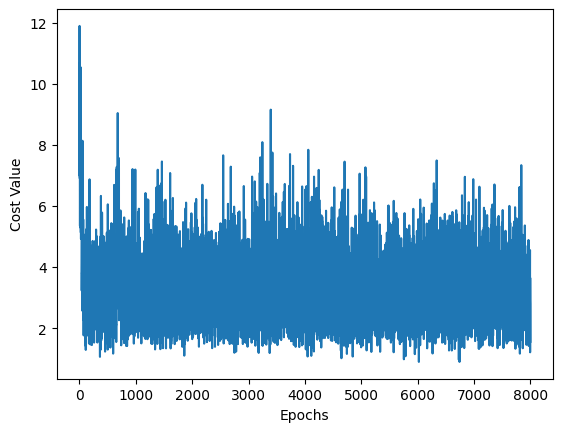

In [23]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(plotting_values)))
y_values = plotting_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

In [24]:
specs_func = qml.specs(circuit)
specs_func(result.x)

{'resources': Resources(num_wires=6, num_gates=45, gate_types=defaultdict(<class 'int'>, {'RY': 24, 'CZ': 20, 'Hadamard': 1}), gate_sizes=defaultdict(<class 'int'>, {1: 25, 2: 20}), depth=15, shots=Shots(total_shots=None, shot_vector=())),
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_trainable_params': 0,
 'num_device_wires': 6,
 'device_name': 'lightning.gpu',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 'NotSupported: Computing the gradient of circuits that return the state with the parameter-shift rule gradient transform is not supported, as it is a hardware-compatible method.'}

In [25]:
np.savetxt('5_qubit_data.out', x, delimiter=',')   # X is an array

In [26]:
np.savetxt('5_qubit_weights.out', result.x, delimiter=',')   # weights is an array

In [27]:
# D- = l
l_ind_np = np.array(l_ind)
np.savetxt('5_qubit_negative_indices.out', l_ind_np, delimiter=',')